Cette page cherche à fournir une indication graphique de la representatitivté des corpus de lemmatisation. On se sert pour cela des corpus et d'une datation par oeuvre et par auteur.

In [1]:
# Change directory to the root of These for simpler imports
from collections import namedtuple
# Imports
from pandas import DataFrame, Series
import lxml.etree as ET
import csv
from IPython.display import display, HTML

## Récupération des dates de corpora

In [2]:
Date = namedtuple("Date", ["birth", "death"])
dates = {}
NomsFr = {}

# On ouvre le fichier qui contient les dates
with open("../../data/raw/datation.tsv") as f:
    reader = csv.DictReader(f, delimiter="\t")
    # Pour chacune des URN, on remplit avec le textgroup le dictionnaire data
    for line in reader:
        urn = line["URN"]
        # Si on a une URN et que cette ligne ne doit pas être ignorée
        if urn and line["Ignore"] != "x":
            textgroup = urn.split(".")[0]
            if textgroup not in dates:
                if not line["Birth"].lstrip('-').isdigit():
                    print("Error at following line")
                    print(line)
                else:
                    dates[textgroup] = Date(int(line["Birth"]), int(line["Death"]))
        else:
            print(f"Ignored {line['Work title']} / {line['Nom FR']}")
            
        if line.get("Nom FR"):
            nom_fr = line['Nom FR']
            if textgroup not in NomsFr:
                NomsFr[textgroup] = nom_fr
            
all_dates = list([d for tup in dates.values() for d in tup])
Min_date, Max_date = min(all_dates), max(all_dates)
print(Min_date, Max_date)

Ignored None / Celse
Ignored None / Pseudo-Hilarius
Ignored None / Cornelius Labeo
Ignored None / Pierre le Diacre
Error at following line
{'S': '', 'Ignore': '', 'URN': 'urn:cts:latinLit:stoa0359.stoa004.digilibLT-lat1', 'Nom FR': 'Vita Vergilii (Bernensis)', 'Birth': '', 'Death': '', 'certainty': '', 'Citation level': '0', 'Name of citation level': 'paragraph', 'Sources': 'DigilibLT', 'Sources Pages': 'https://digiliblt.uniupo.it/opera.php?gruppo=opere&iniziale=all&id=dlt000583', 'Notes': '', 'Nom ENG': 'Vita Vergilii (Bernensis)', 'Work title': 'Vita Vergilii (Bernensis)'}
Ignored None / Celse
Ignored None / Granius Licinianus
Ignored None / Rémi d'Auxerre
Ignored None / Claudius Marius Victor
-254 900


## Parsage des corpora

### Récupérations des décomptes de mot

In [3]:
# Les corpora sont lus à la source, chaque fichier parsé
# Ils sont aussi alignés avec des URNs
import glob
from collections import defaultdict
import tqdm
import numpy as np

words = defaultdict(lambda:0)
formats = defaultdict(lambda: defaultdict(lambda: 0))
sources = defaultdict(lambda: 0)

TextDataColumns = ["textgroup", "fullUrn", "words", "rend", "source", "birth", "death"]
TextData = namedtuple("TextData", TextDataColumns)

texts = []
for file in tqdm.tqdm(glob.glob("../../../latin-lemmatized-texts/lemmatized/xml/*.xml")):
    tg = file.split("/")[-1].split(".")[0]
    xml = ET.parse(file)
    w = len(xml.xpath("//tei:w", namespaces={"tei": "http://www.tei-c.org/ns/1.0"}))
    #words[tg] += w
    rend = str(xml.xpath("//@rend", namespaces={"tei": "http://www.tei-c.org/ns/1.0"})[0])
    #formats[tg][rend] += w  
    source = "/".join(xml.xpath("//tei:link/@target", namespaces={"tei": "http://www.tei-c.org/ns/1.0"})[0].split("/")[3:5])
    texts.append(
        TextData(tg, file.split("/")[-1].replace(".xml", ""), w, rend, source, *dates.get(tg, (np.nan, np.nan)))
    )

100%|██████████| 853/853 [01:14<00:00, 11.39it/s]


### Dataframe principale

In [4]:
from pandas import Int64Dtype

df = DataFrame(texts, columns=TextDataColumns)
df.birth = df.birth.astype(Int64Dtype())
df.death = df.death.astype(Int64Dtype())
df["Auteur"] = df.textgroup.apply(lambda x: NomsFr.get(x, x))

### Manque de dates

In [5]:
df[df.birth.isna()].sort_values("textgroup")

,textgroup,fullUrn,words,rend,source,birth,death,Auteur
694,urn:cts:latinLit:phi1257,urn:cts:latinLit:phi1257.phi001.digilibLT-lat1,6953,book,ponteineptique/digiliblt,<NA>,<NA>,urn:cts:latinLit:phi1257
674,urn:cts:latinLit:stoa0170a,urn:cts:latinLit:stoa0170a.stoa001.digilibLT-lat1,1552,unknown,ponteineptique/digiliblt,<NA>,<NA>,urn:cts:latinLit:stoa0170a
126,urn:cts:latinLit:stoa0227b,urn:cts:latinLit:stoa0227b.stoa001.opp-lat1,5173,section,OpenGreekAndLatin/csel-dev,<NA>,<NA>,urn:cts:latinLit:stoa0227b
824,urn:cts:latinLit:stoa0241d,urn:cts:latinLit:stoa0241d.stoa002.opp-lat1,15463,book,OpenGreekAndLatin/csel-dev,<NA>,<NA>,urn:cts:latinLit:stoa0241d
490,urn:cts:latinLit:stoa0359,urn:cts:latinLit:stoa0359.stoa004.digilibLT-lat1,155,paragraph,ponteineptique/digiliblt,<NA>,<NA>,Vita Vergilii (Bernensis)


In [6]:
# Nombre d'oeuvres
print(len(df.textgroup.unique()))

204


## Graphiques

### Imports

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def set_non_scientific(axis):
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)

    
sns.set_palette("Greys_r")
sns.set_style('whitegrid')

### Tailles des textes

\begin{tabular}{lllllllll}
\toprule
{} &      0 &             1 &             2 &      3 &       4 &       5 &        6 &          7 \\
\midrule
index &  count &          mean &           std &    min &     25\% &     50\% &      75\% &        max \\
words &  853.0 &  25003.262603 &  59386.633038 &  126.0 &  3188.0 &  8697.0 &  20639.0 &  1036035.0 \\
\bottomrule
\end{tabular}

textgroup    80
fullUrn      80
words        80
rend         80
source       80
birth        79
death        79
Auteur       80
dtype: int64
textgroup    49
fullUrn      49
words        49
rend         49
source       49
birth        49
death        49
Auteur       49
dtype: int64


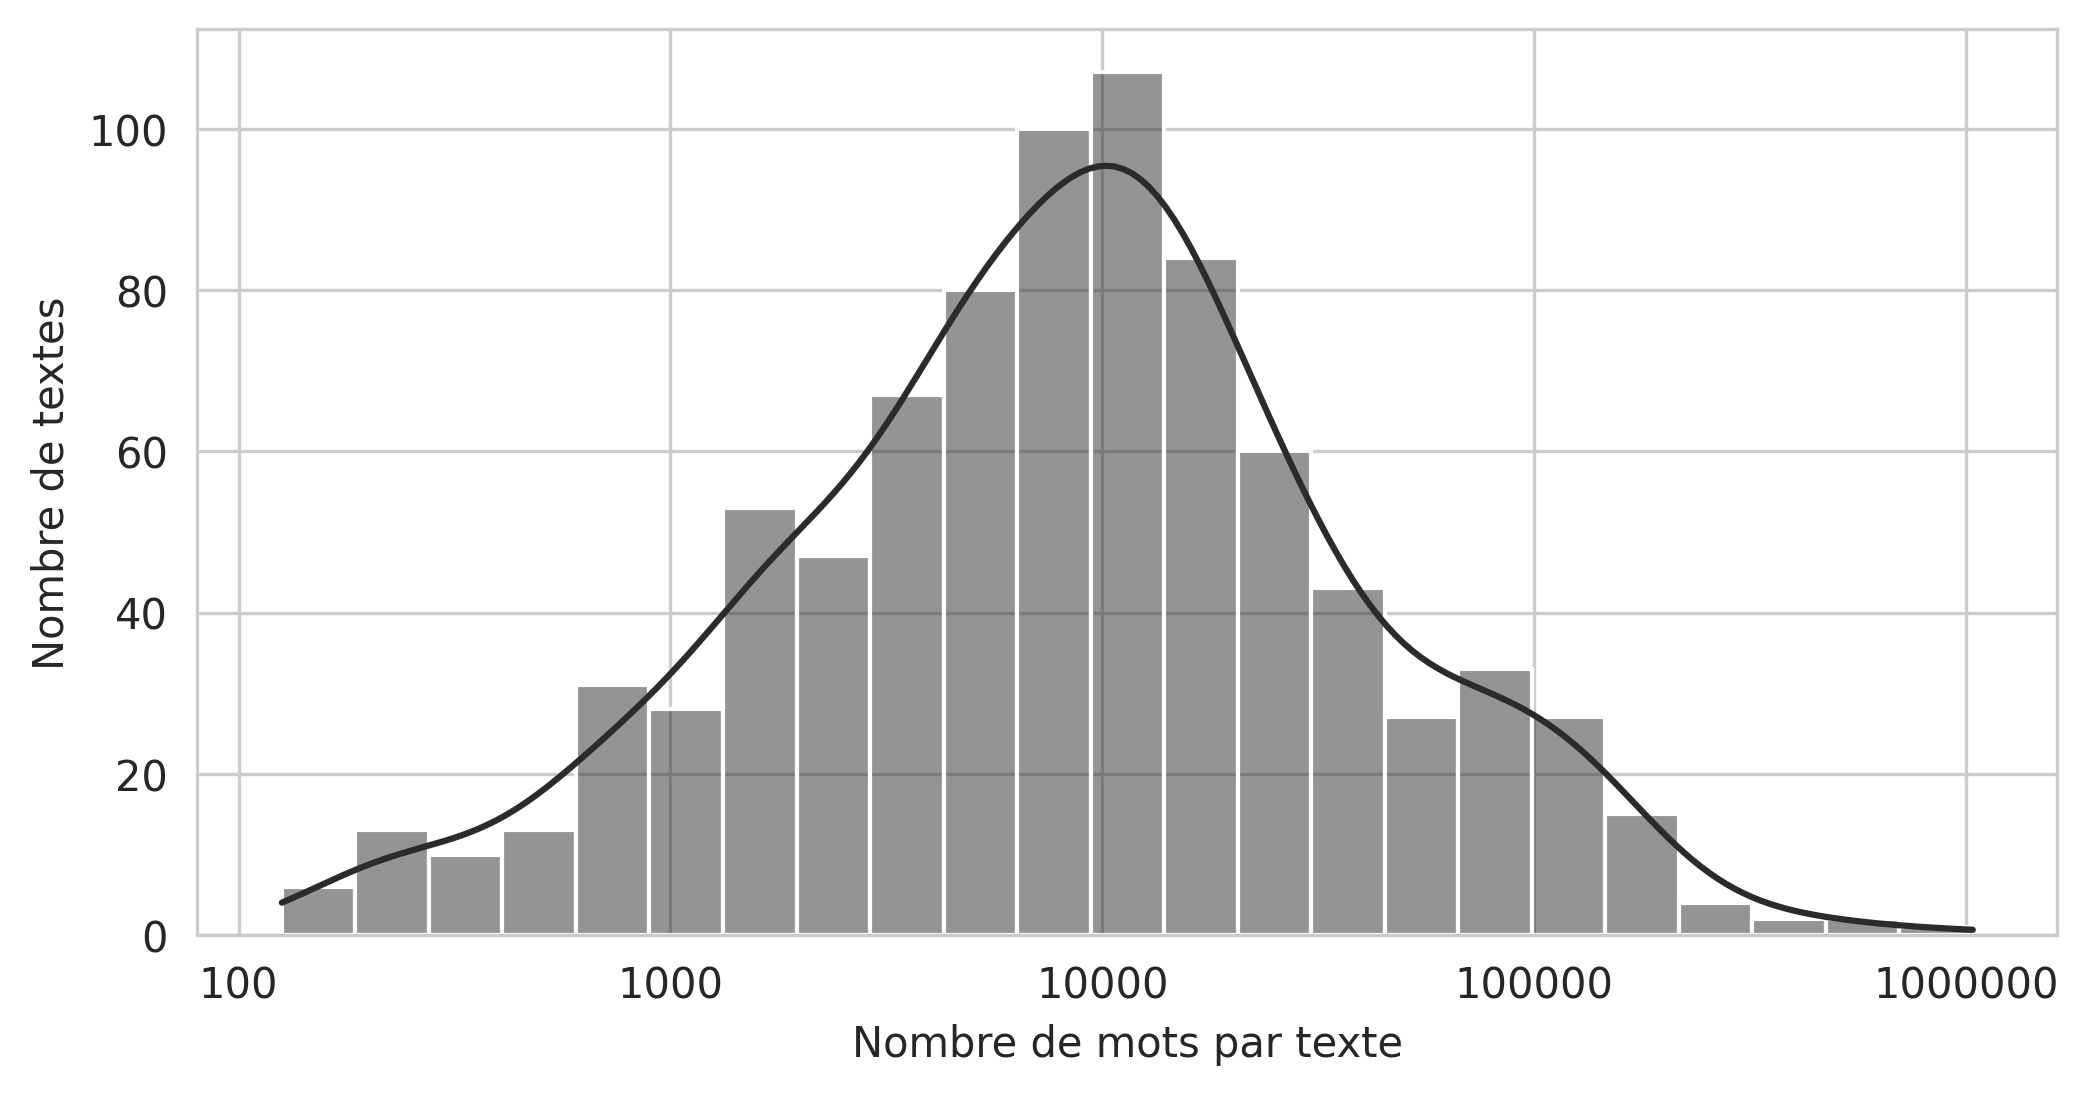

In [8]:
sns.set_palette("Greys_r")
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.gca()
sns.histplot(df.words.sort_values(), log_scale=True, kde=True, ax=ax)
ax.set_ylabel("Nombre de textes")
ax.set_xlabel("Nombre de mots par texte")
#ax.xaxis.set_major_formatter(non_scientific)
set_non_scientific(ax.xaxis)
print(df.words.describe().reset_index().transpose().to_latex())
print(df[df.words < 1000].count())
print(df[df.words > 100000].count())

### Oeuvres / auteur

204


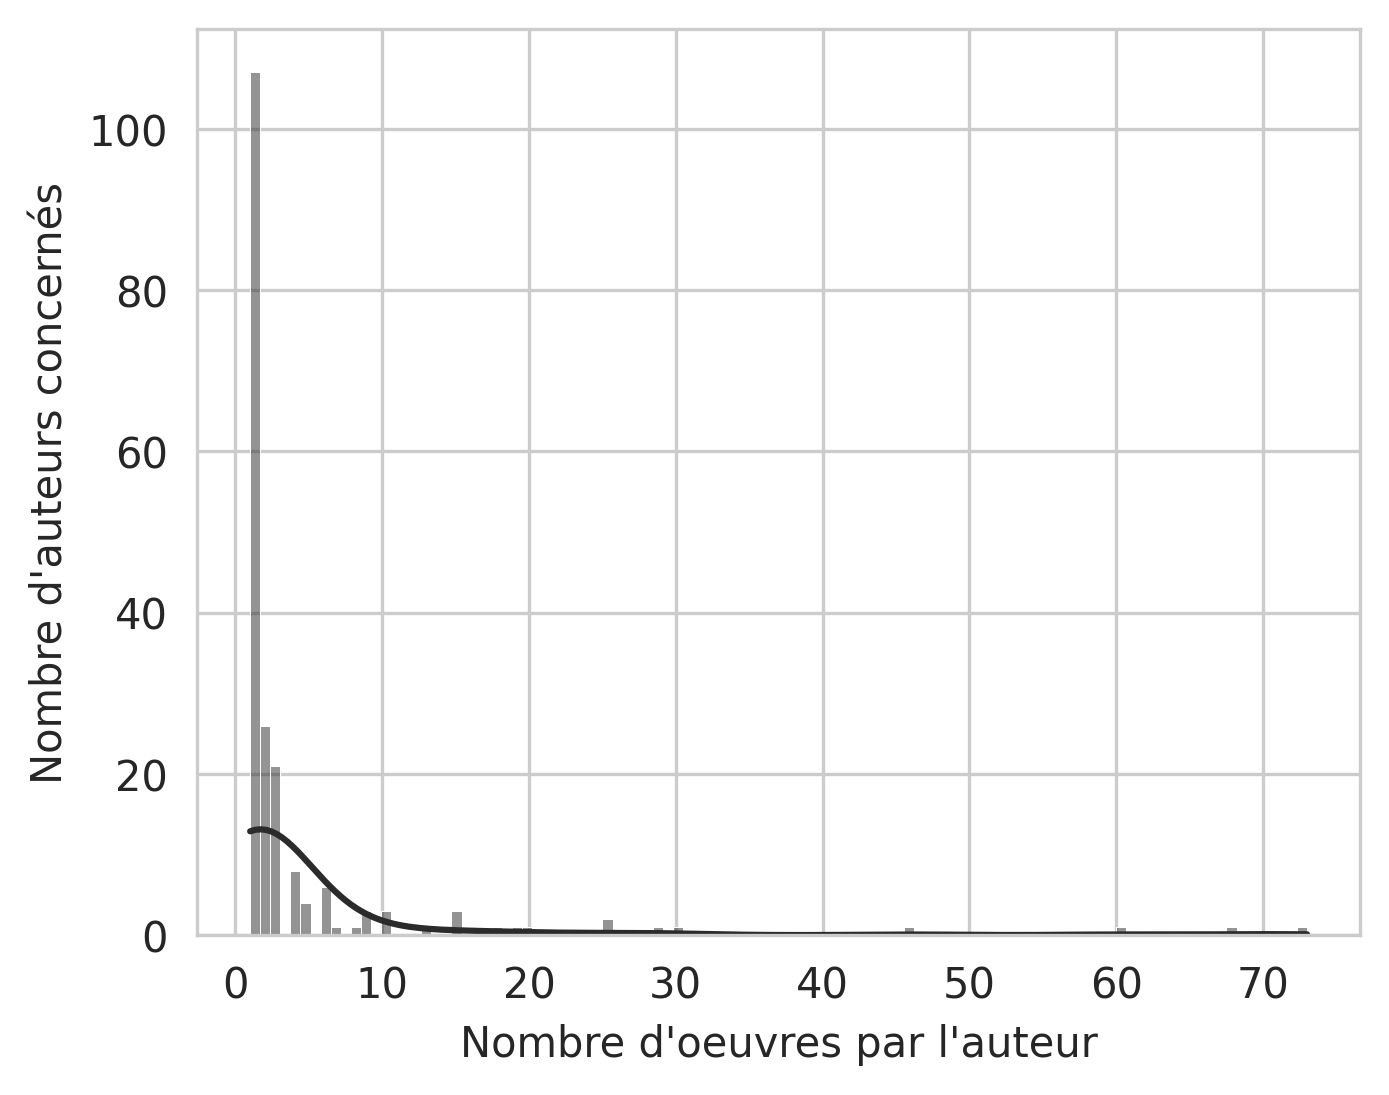

In [9]:
sns.set_palette("Greys_r")
fig = plt.figure(figsize=(5, 4), dpi=300)
ax = fig.gca()
data = df.Auteur.value_counts().value_counts().reset_index()
data.columns = ["Oeuvres", "Auteurs"]
#data.plot.scatter(x="Oeuvres", y="Auteurs", ax=ax, marker="x")
sns.histplot(df.Auteur.value_counts(), ax=ax, kde=True)
#sns.lmplot(x='Oeuvres',y='Auteurs',data=data, fit_reg=True, ax=ax) 
#sns.scatterplot(data, x=data["Oeuvres"], y=data["Auteurs"], ax=ax)#, scale="log")
#plt.yscale('log', nonposy='clip')
ax.set_xlabel("Nombre d'oeuvres par l'auteur")
ax.set_ylabel("Nombre d'auteurs concernés")
#ax.xaxis.set_major_formatter(non_scientific)
#set_non_scientific(ax.xaxis)
print(len(df.textgroup.unique()))

### Cumul date

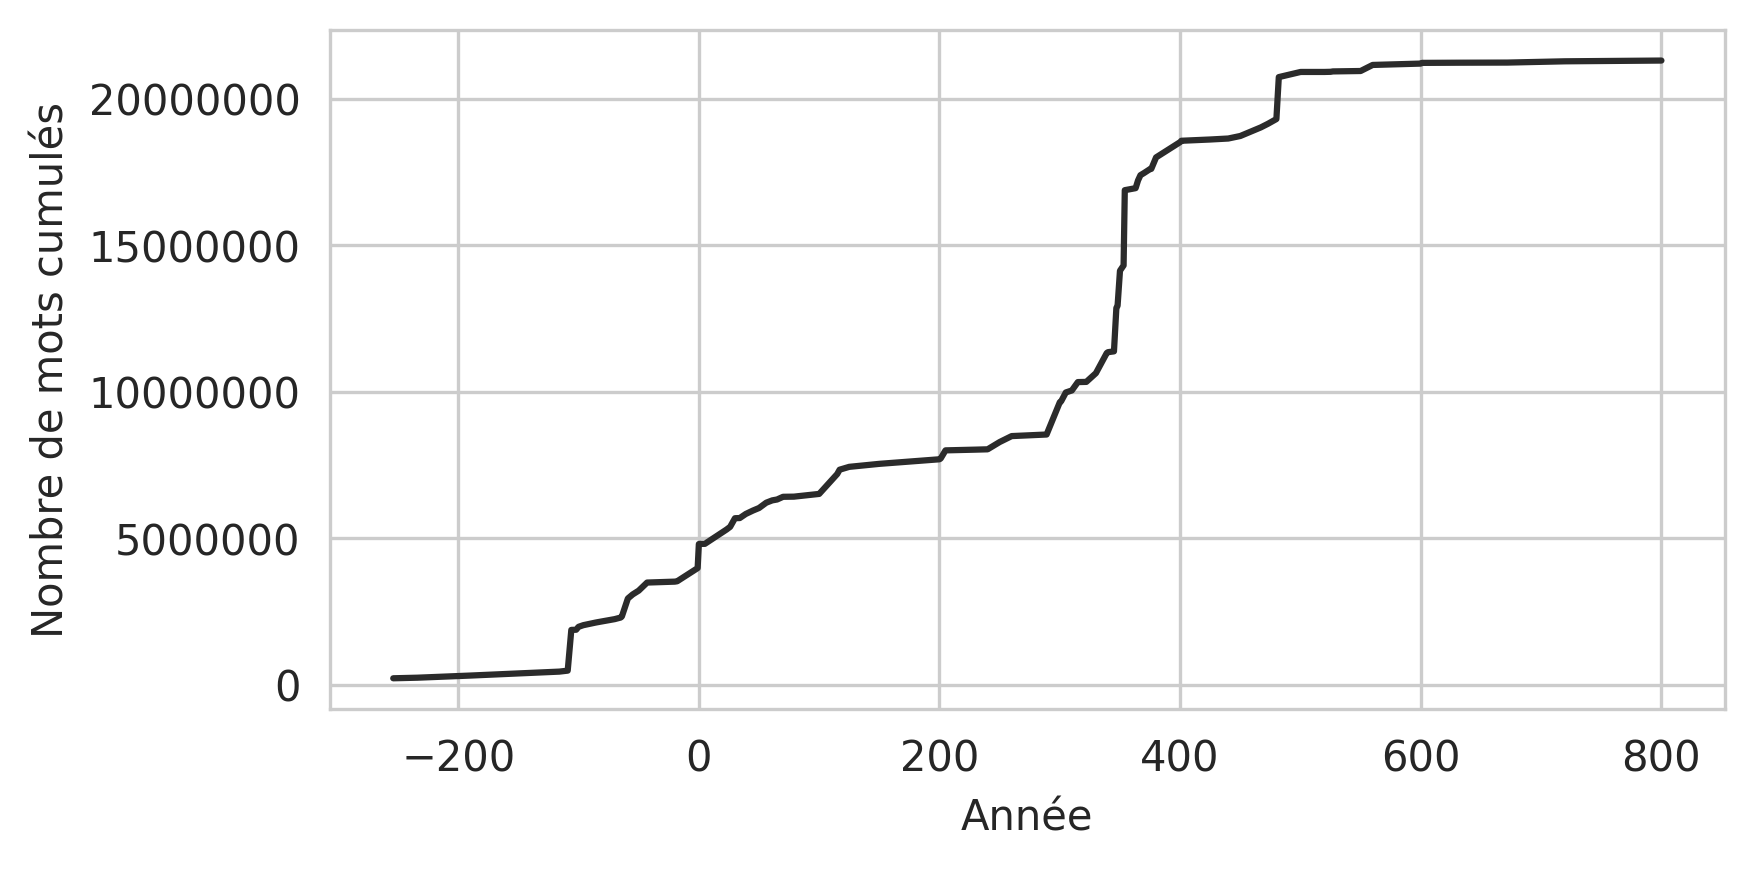

In [10]:
NotNaNDF = df[df.birth != np.nan].sort_values(["birth"]).groupby(['birth'])['words'].sum().reset_index()
NotNaNDF.words = NotNaNDF.words.cumsum()
#sns.ecdfplot(data=NotNaNDF, x=NotNaNDF.birth, y=NotNaNDF.words)
sns.set_palette("Greys_r")
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.gca()
sns.lineplot(data=NotNaNDF, x=NotNaNDF.birth, y=NotNaNDF.words, ax=ax)
ax.set_ylabel("Nombre de mots cumulés")
ax.set_xlabel("Année")
set_non_scientific(ax.yaxis)

### Cumul date / forme

                          Naissance      Mots
Forme                                        
(partiellement) versifié        500   1626962
prose                           800  19671525


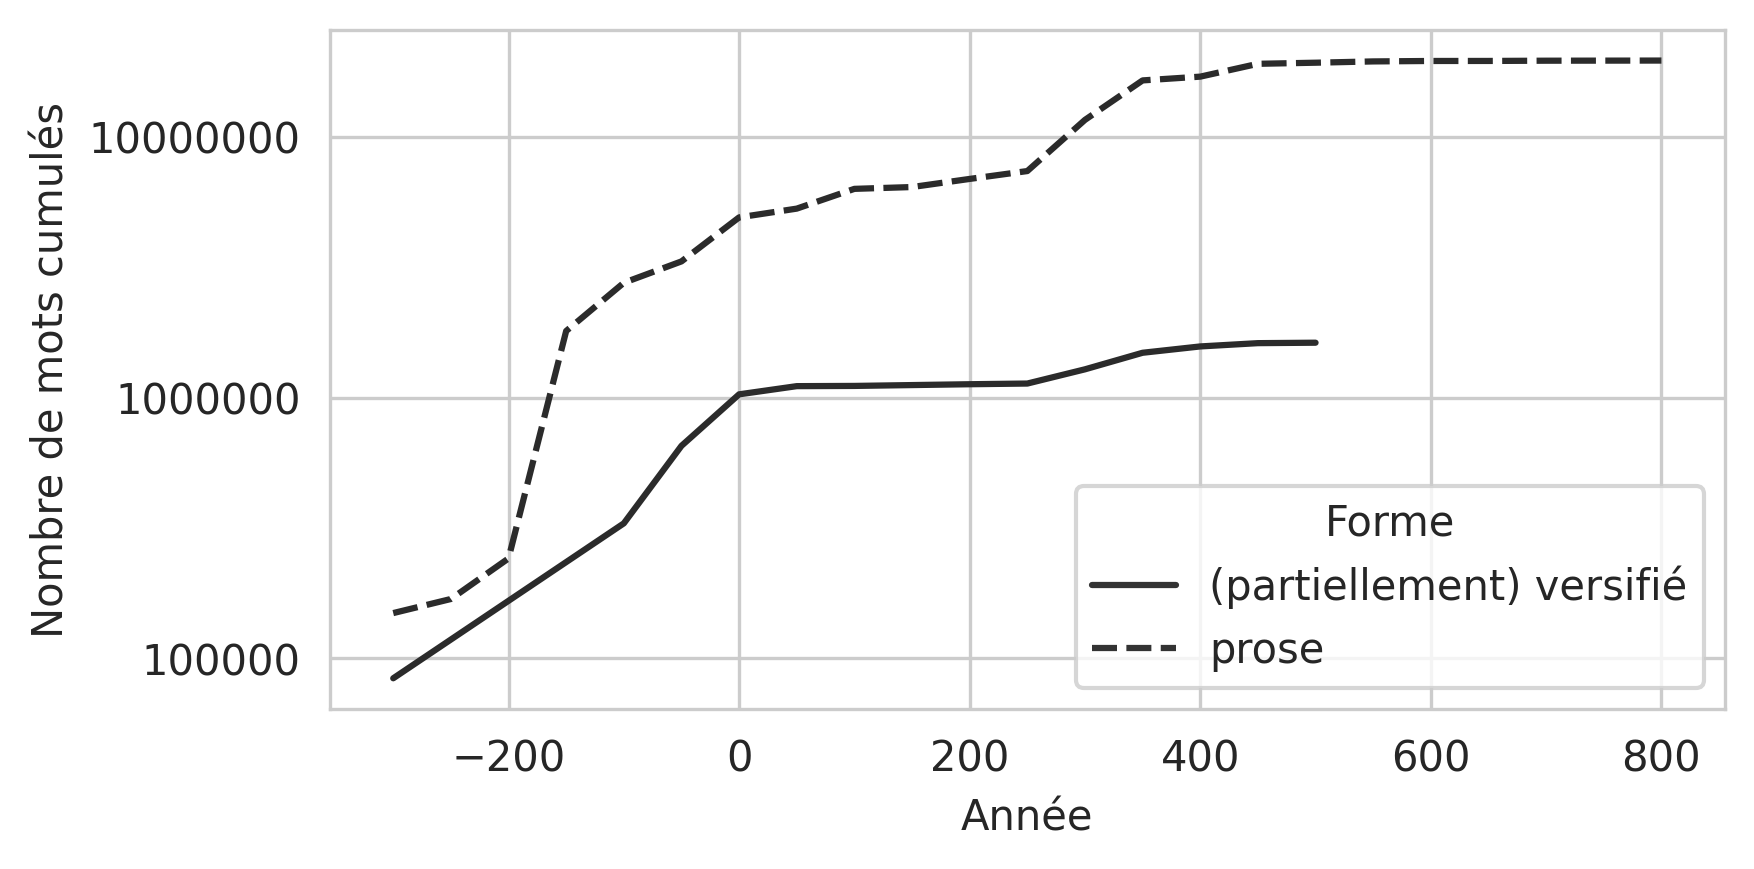

In [11]:
NotNaNDF = df[df.birth != np.nan].sort_values(["birth"])
NotNaNDF.rend = NotNaNDF.rend.apply(
    lambda x: "(partiellement) versifié" if x in {"line", "poem", "section|line", "paragraph|line"} else "prose"
)
DateRange = 50
# (int(x % DateRange > 0) + 
NotNaNDF.birth = NotNaNDF.birth.apply(lambda x: (x // DateRange) * DateRange)
NotNaNDF = NotNaNDF.groupby(['birth', "rend"])["words"].sum().groupby(["rend"]).cumsum().reset_index()
NotNaNDF.columns = ["Naissance", "Forme", "Mots"]
#print(NotNaNDF)
#NotNaNDF.words = NotNaNDF.words.cumsum()
#sns.ecdfplot(data=NotNaNDF, x=NotNaNDF.birth, y=NotNaNDF.words)
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.gca()
sns.lineplot(
    data=NotNaNDF, 
    x=NotNaNDF.Naissance, 
    y=NotNaNDF.Mots, 
    style=NotNaNDF.Forme, 
    ax=ax, 
    #dashes=0, 
    #'markers=['o','x']
)
ax.set(yscale='log')
ax.set_ylabel("Nombre de mots cumulés")
ax.set_xlabel("Année")
set_non_scientific(ax.yaxis)
print(NotNaNDF.groupby("Forme").max())

### Cumul date / source

<ipython-input-12-ad96108e7a71>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsetDf["MotsPercents"] = subsetDf.apply(lambda x: x.Mots / maxes[x.Source], axis=1)


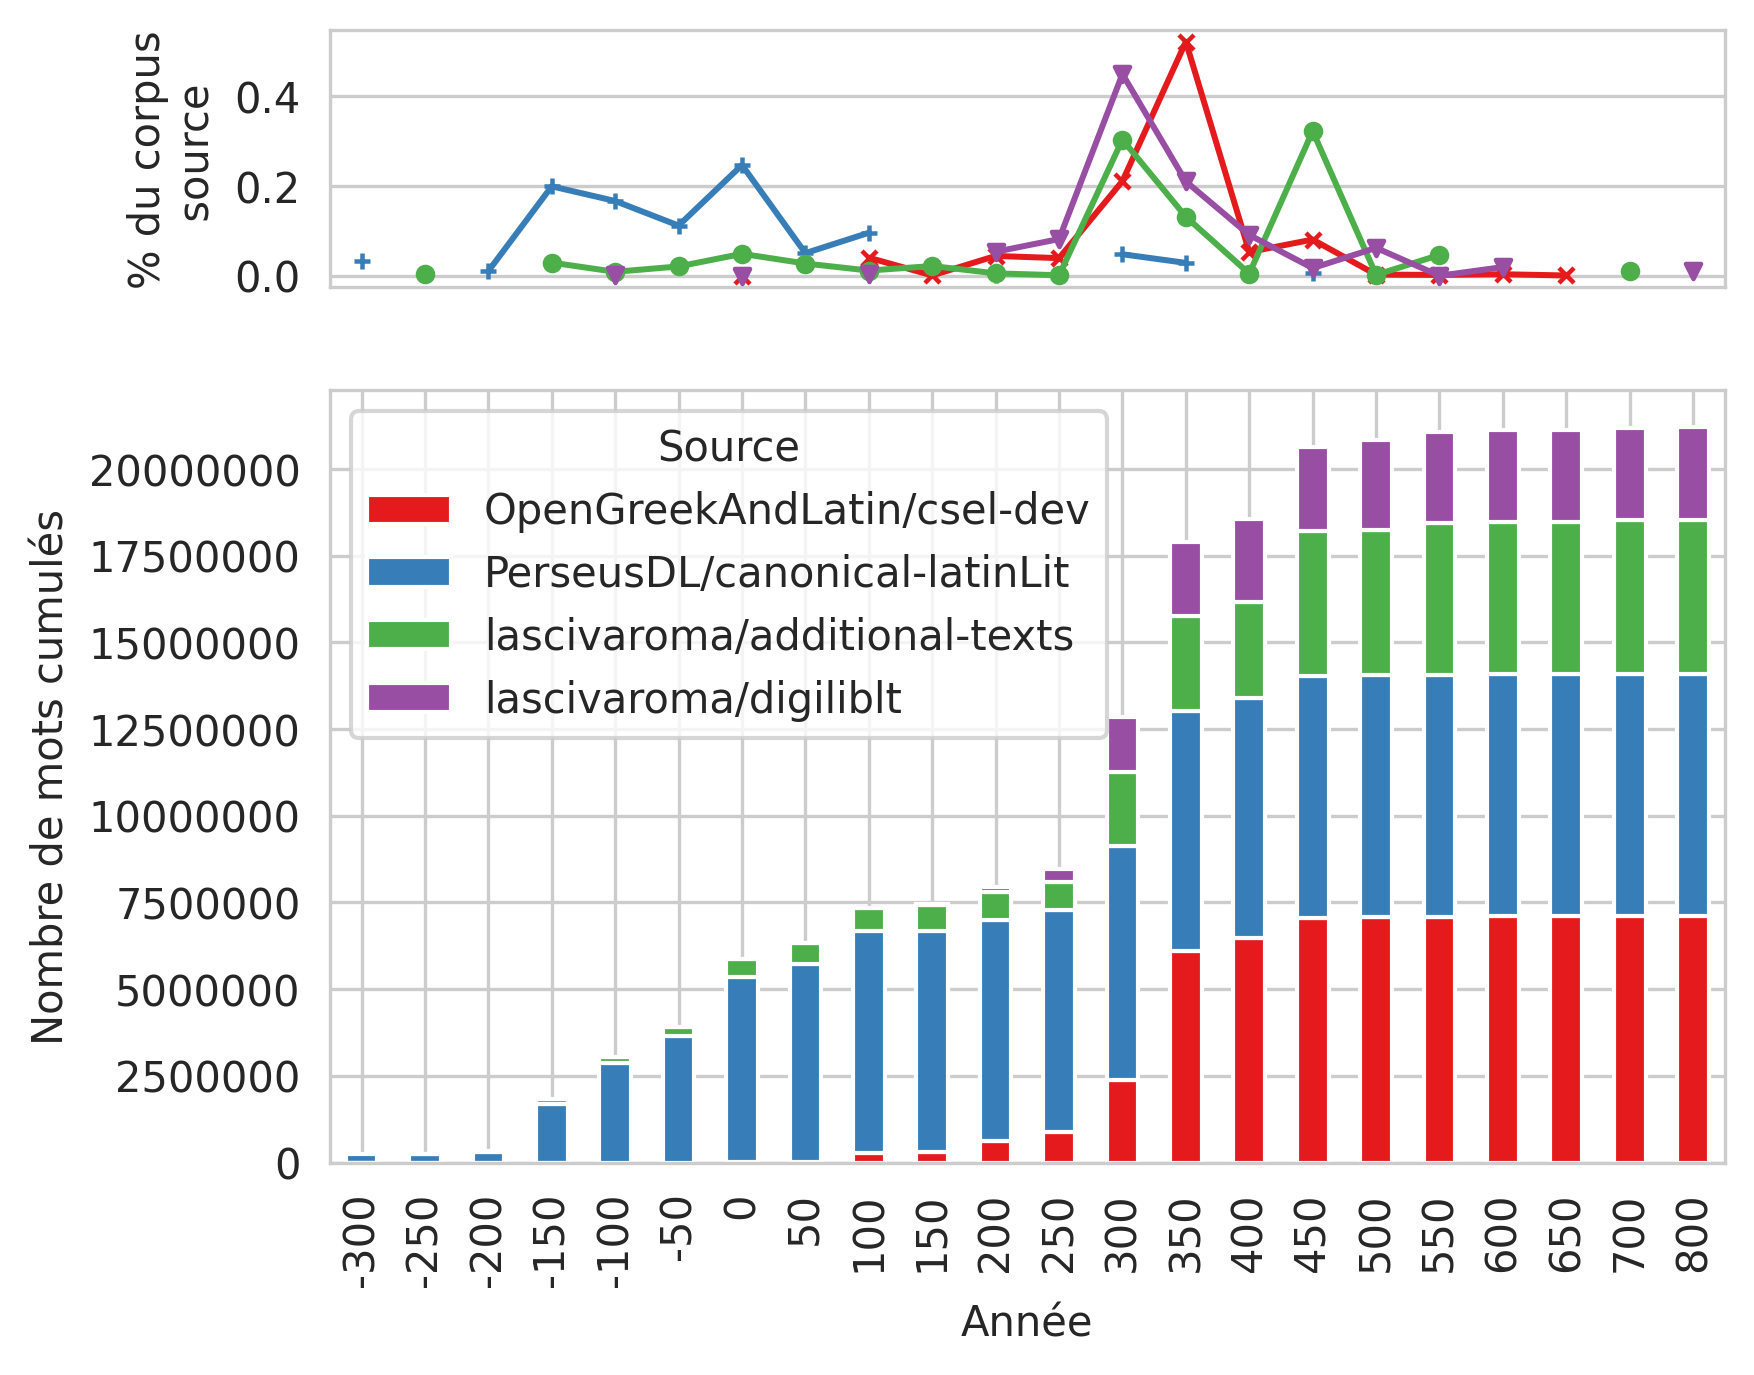

In [12]:
from pandas import pivot_table

sns.set_palette("Set1")

DateRange = 50


NotNaNDF = df[df.birth != np.nan].sort_values(["birth"])
NotNaNDF.source = NotNaNDF.source.apply(
    lambda x: "lascivaroma/digiliblt" if "digiliblt" in x else x
)
NotNaNDF.birth = NotNaNDF.birth.apply(lambda x: (x // DateRange) * DateRange)

NotNaNDF = NotNaNDF.groupby(['birth', "source"])["words"].sum().reset_index()
NotNaNDF.columns = ["Naissance", "Source", "Mots"]



fig, (ax2, ax) = plt.subplots(2, 1, figsize=(6, 5), dpi=300, gridspec_kw={'height_ratios': [1, 3]})
#ax = fig.gca()
tble = pivot_table(NotNaNDF, values='Mots', index=['Naissance'], columns=['Source'], fill_value=0)

tble_cs = tble[[col for col in tble.columns if "/Latin" not in col and "priap" not in col]].cumsum()#*list(tble.columns))
tble_cs.plot.bar(ax=ax, legend=True, stacked=True)

tble_nonacc = tble[[col for col in tble.columns if "/Latin" not in col and "priap" not in col]]
#tble_nonacc.plot.area(ax=ax, legend=False)
#ax.set(yscale='log')
ax.set_ylabel("Nombre de mots cumulés")
ax.set_xlabel("Année")
set_non_scientific(ax.yaxis)

#bars = ax.patches
#patterns =('o', '/','x','O')
#hatches = [p for p in patterns for i in range(len(tble))]
#for bar, hatch in zip(bars, hatches):
#    bar.set_hatch(hatch)

#fig = plt.figure(figsize=(6, 1), dpi=300)
#ax = fig.gca()
Corpora = [
    col
    for col in tble.columns
    if "/Latin" not in col and "priap" not in col
]
subsetDf = NotNaNDF[
    NotNaNDF.Source.isin(Corpora)
]
maxes = {
    corp: tble_cs[corp].max()
    for corp in Corpora
}
subsetDf["MotsPercents"] = subsetDf.apply(lambda x: x.Mots / maxes[x.Source], axis=1)
#print([tble_nonacc[col] for col in tble_nonacc.columns])
with plt.rc_context({'lines.linewidth': 0.8}):
    sns.pointplot(
        data=subsetDf,
        ax=ax2,
        x=subsetDf.Naissance,
        y=subsetDf.MotsPercents,
        hue=subsetDf.Source,
        hue_order = Corpora,
        line=False,
        join=True,
        #legend=False,
        #yaxis="log",
        markers=["x", "+", "o", "v"],
        #kde=True
    )
ax2.get_legend().remove()
_ = ax2.set_xticklabels("")
#_ = ax2.set_yticklabels()
_ = ax2.set_xlabel("")
_ = ax2.set_ylabel("% du corpus\n source")
subsetDf.to_csv("../../data/exported-authors-wordscount.csv")

In [13]:
df[df.birth.between(250, 350)].sort_values("birth").groupby("textgroup").words.sum().reset_index().sort_values("words")

,textgroup,words
51,urn:cts:latinLit:stoa0349,389
40,urn:cts:latinLit:stoa0218,1272
47,urn:cts:latinLit:stoa0251,2078
7,urn:cts:latinLit:stoa0013c,3188
31,urn:cts:latinLit:stoa0187a,4330
35,urn:cts:latinLit:stoa0209,5010
22,urn:cts:latinLit:stoa0122c,5776
44,urn:cts:latinLit:stoa0234f,6209
34,urn:cts:latinLit:stoa0208a,7350
52,urn:cts:latinLit:stoa0353,7920


### Informations sur les corpora

## Parsage des informations sur les corpus généraux

### Informations issues du catalogue (Parcellaires)

In [14]:
import glob
import os
sha = "e8b7ad7e87d53e265e8052a7f30e589a87a73e3f"
mods_path = f"../../data/raw/metadatas/PerseusDL_catalog_data/catalog_data-{sha}/mods"

token_count = {}
MISSING = []

for textgroup_dir in glob.glob(os.path.join(mods_path, "latinLit", "**")):
    textgroup = "urn:cts:{ns}:{tg}".format(
        ns="latinLit",
        tg=textgroup_dir.split("/")[-1]
    )

    tg_dates = dates.get(textgroup)
    if not tg_dates:
        if "latinLit"in textgroup:
            MISSING.append(textgroup)
        continue

    for work_dir in glob.glob(os.path.join(textgroup_dir, "**")):
        max_count = 0
        urn = textgroup+"."+work_dir.split("/")[-1]

        for edition_mods_file in glob.glob(os.path.join(work_dir, "**", "*.xml")):
            basename = os.path.basename(edition_mods_file)
            urn = "urn:cts:{ns}:{version}".format(
                ns="latinLit",
                version=basename.replace("mods1.xml", "")
            )
            work = ".".join(urn.split(".")[:-2])
            try:
                with open(edition_mods_file) as mods_io_wrapper:
                    mods_xml = ET.parse(mods_io_wrapper)
                    word_count = mods_xml.xpath("//mods:extent[@unit='words']/mods:total/text()", namespaces={
                        "mods": "http://www.loc.gov/mods/v3"
                    })
                    if word_count:
                        word_count = int(word_count[0])
                        if max_count < word_count:
                            max_count = word_count
            except:
                raise
                continue
        token_count[work] = max_count
        
        if max_count > 0 and tg_dates == None:
            print(f"{tg_dates} has its dates missing and has a word count")

In [15]:
PerseusCatalogDict = [
    {
        "work": wk, 
        "words": wds, 
        "textgroup": ".".join(wk.split(".")[:-1]), 
        "birth": dates[".".join(wk.split(".")[:-1])][0]
    }
    for (wk, wds) in token_count.items()
    if wds > 0
]

### Écart sur les périodes

In [16]:
PerseusCatalogDf = DataFrame(PerseusCatalogDict).sort_values("birth")
DateRange = 50
# (int(x % DateRange > 0) + 
#NotNaNDF.birth = NotNaNDF.birth.apply(lambda x: (x // DateRange) * DateRange)
#NotNaNDF = NotNaNDF.groupby(['birth', "rend"])["words"].sum().groupby(["rend"]).cumsum().reset_index()
PerseusCatalogDf.birth = PerseusCatalogDf.birth.apply(lambda x: (x // DateRange) * DateRange)
PerseusCatalogDf = PerseusCatalogDf.groupby(["birth"]).words.sum().cumsum().reset_index()
PerseusCatalogDf["source"] = "Perseus Catalog"

In [17]:
LLC = df[df.birth != np.nan].sort_values(["birth"])
LLC.birth = LLC.birth.apply(lambda x: (x // DateRange) * DateRange)
LLC = LLC.groupby(['birth'])['words'].sum().reset_index()
LLC.words = LLC.words.cumsum()
LLC["source"] = "Capitains Corpus"

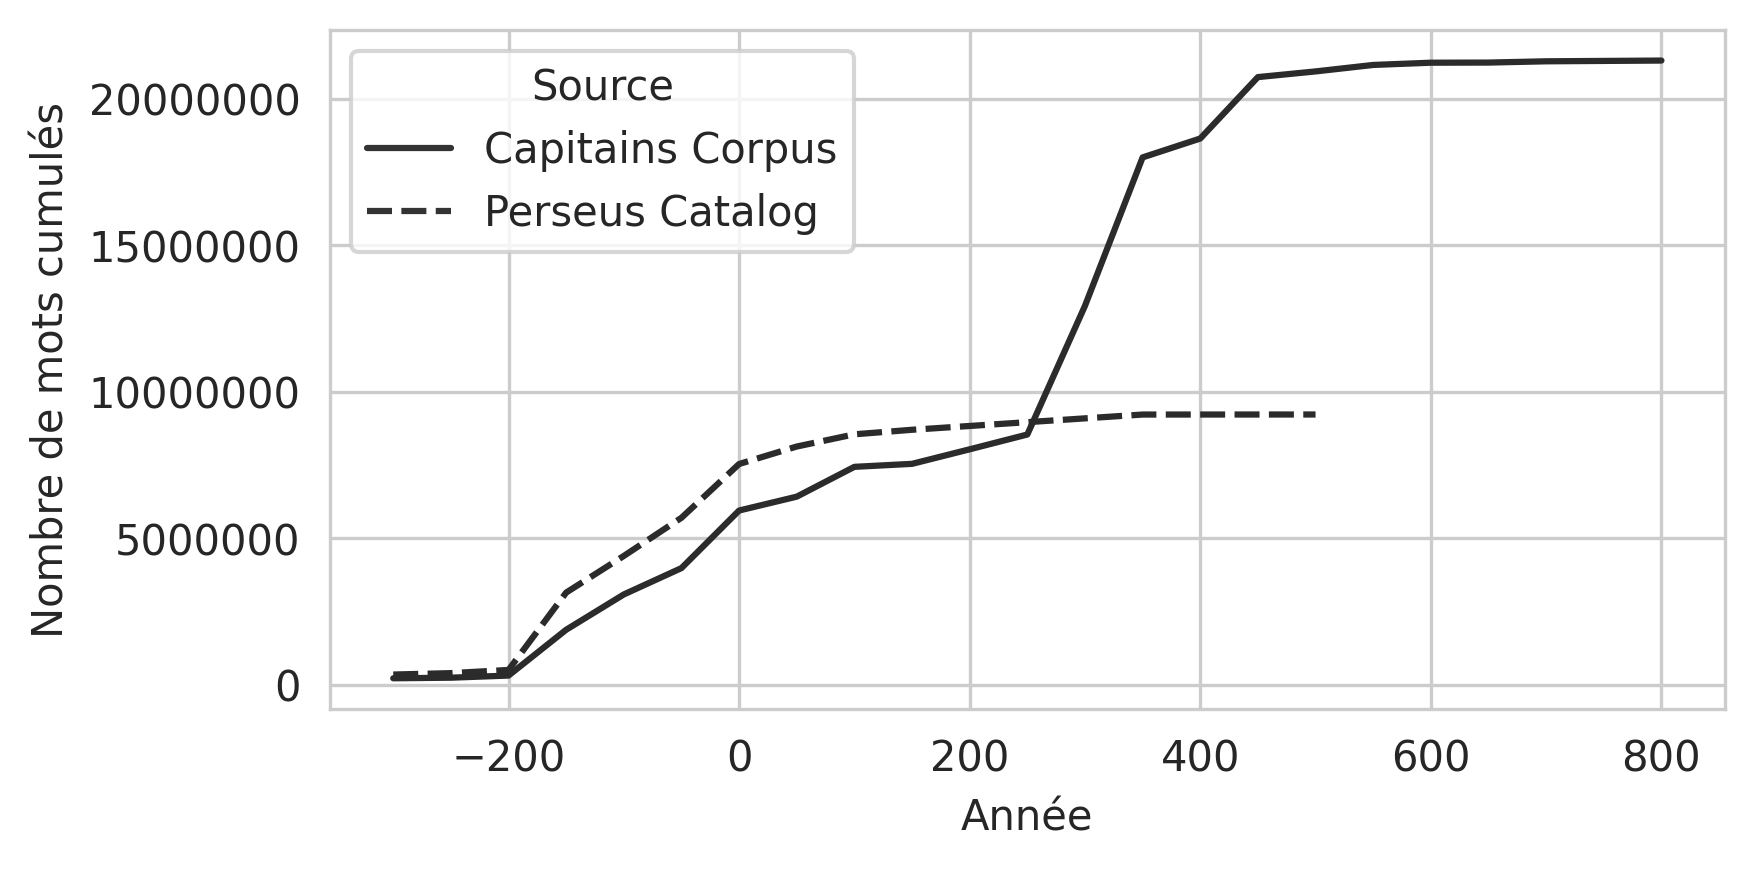

In [18]:
from pandas import concat

Combined = concat([LLC, PerseusCatalogDf])
Combined["Source"] = Combined["source"]

sns.set_palette("Greys_r")
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.gca()
sns.lineplot(data=Combined, x=Combined.birth, y=Combined.words, style=Combined.Source, ax=ax)
ax.set_ylabel("Nombre de mots cumulés")
ax.set_xlabel("Année")
set_non_scientific(ax.yaxis)

### Écart par auteur

<AxesSubplot:xlabel='Auteur'>

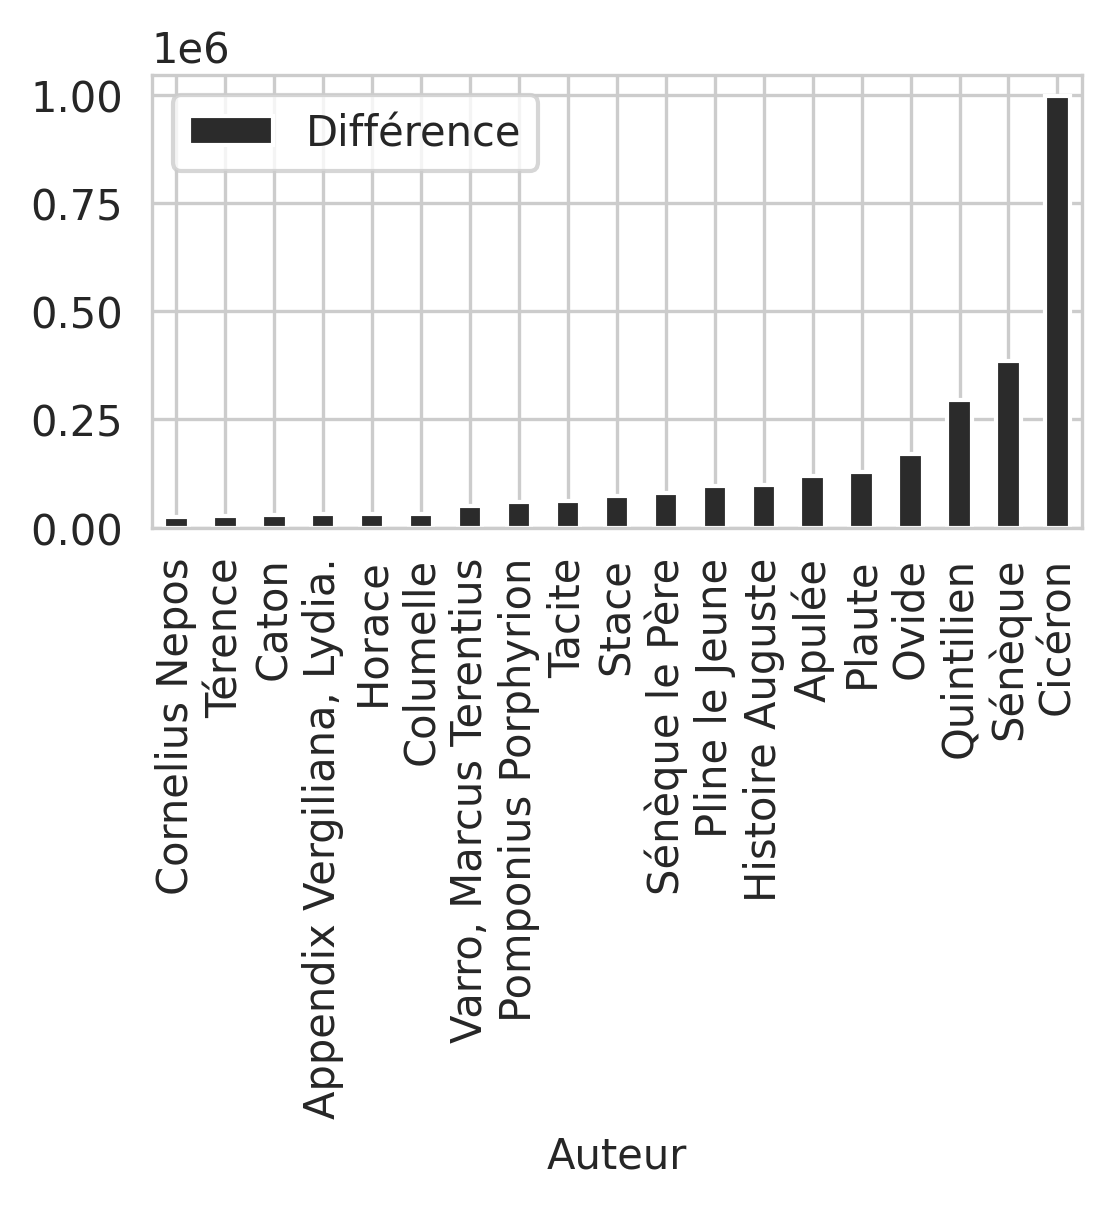

In [19]:
PerseusCatalogDf = DataFrame(PerseusCatalogDict).sort_values("birth").groupby("textgroup").words.sum().reset_index()
PerseusCatalogDf["source"] = "Perseus Catalog"
PerseusCatalogDf["Perseus Catalog"] = PerseusCatalogDf.words
LLC = df[df.birth != np.nan].sort_values(["birth"]).groupby("textgroup").words.sum().reset_index()
LLC["source"] = "Capitains"
LLC["Capitains"] = LLC.words

from pandas import merge

MergedDf = merge(LLC, PerseusCatalogDf, on="textgroup")
MergedDf["Différence"] = MergedDf["Perseus Catalog"] - MergedDf["Capitains"] 
MergedDf["Auteur"] = MergedDf.textgroup.apply(lambda x: NomsFr.get(x, x))



fig = plt.figure(figsize=(4, 2), dpi=300)
ax = fig.gca()

MergedDf[MergedDf.Différence > 25000].sort_values("Différence").plot.bar(y="Différence", x="Auteur", ax=ax)

In [20]:
MergedDf[MergedDf.Différence > 25000]

,textgroup,words_x,source_x,Capitains,words_y,source_y,Perseus Catalog,Différence,Auteur
0,urn:cts:latinLit:phi0022,19788,Capitains,19788,48097,Perseus Catalog,48097,28309,Caton
1,urn:cts:latinLit:phi0119,233258,Capitains,233258,360643,Perseus Catalog,360643,127385,Plaute
2,urn:cts:latinLit:phi0134,72943,Capitains,72943,99888,Perseus Catalog,99888,26945,Térence
5,urn:cts:latinLit:phi0474,1389163,Capitains,1389163,2386999,Perseus Catalog,2386999,997836,Cicéron
8,urn:cts:latinLit:phi0588,33604,Capitains,33604,58851,Perseus Catalog,58851,25247,Cornelius Nepos
12,urn:cts:latinLit:phi0684,134461,Capitains,134461,184350,Perseus Catalog,184350,49889,"Varro, Marcus Terentius"
14,urn:cts:latinLit:phi0692,1488,Capitains,1488,31848,Perseus Catalog,31848,30360,"Appendix Vergiliana, Lydia."
17,urn:cts:latinLit:phi0845,95256,Capitains,95256,127089,Perseus Catalog,127089,31833,Columelle
20,urn:cts:latinLit:phi0893,53801,Capitains,53801,84913,Perseus Catalog,84913,31112,Horace
25,urn:cts:latinLit:phi0959,275971,Capitains,275971,445626,Perseus Catalog,445626,169655,Ovide


## Quelques stats

In [21]:
AuteursCreateurs = df.sort_values("birth")
AuteursCreateurs["Auteur"] = AuteursCreateurs.textgroup.apply(lambda x: NomsFr.get(x, x))
AuteursCreateurs = AuteursCreateurs.groupby("Auteur").words.sum().reset_index().sort_values("words")
AuteursCreateurs["Mots"] = AuteursCreateurs.words
#print(AuteursCreateurs[["Auteur", "Mots"]].tail(10).to_latex(index=False))
AuteursCreateurs[AuteursCreateurs.Auteur == "Tertullien"]


,Auteur,words,Mots
169,Tertullien,668335,668335


In [22]:
Oeuvres = df.sort_values("birth")
Oeuvres["Auteur"] = Oeuvres.textgroup.apply(lambda x: NomsFr.get(x, x))
Oeuvres = Oeuvres.groupby("Auteur").words.count().reset_index().sort_values("words")
Oeuvres["Oeuvres"] = Oeuvres.words
#print(Oeuvres[["Auteur", "Oeuvres"]].tail(10).to_latex(index=False))
#Oeuvres[Oeuvres.Auteur == "Jérôme"]
Oeuvres[Oeuvres.Auteur == "Tertullien"]

,Auteur,words,Oeuvres
169,Tertullien,46,46


In [23]:
MergedDf = merge(AuteursCreateurs[["Auteur", "Mots"]], Oeuvres[["Auteur", "Oeuvres"]], on="Auteur")
#print(MergedDf[MergedDf.Auteur == "Tertullien"])
#MergedDf = MergedDf.groupby("Auteur").sum().reset_index()#.cumsum("Mots", "Oeuvres")#.reset_index(0)
#print(MergedDf)
MergedDf["Rang Mots"] = MergedDf.Mots.rank(ascending=False, method="min").astype('int32')
MergedDf["Rang Oeuvres"] = MergedDf.Oeuvres.rank(ascending=False, method="min").astype('int32')


#print(MergedDf[MergedDf.textgroup == "urn:cts:latinLit:stoa0275"])
print(MergedDf[["Auteur", "Mots", "Rang Mots", "Oeuvres", "Rang Oeuvres"]].sort_values(["Rang Mots", "Rang Oeuvres"])\
      [(MergedDf["Rang Mots"] <= 10) | (MergedDf["Rang Oeuvres"] <=10)].to_latex(
    index=False,
    formatters={
        "Mots": lambda x: f'{x:,}'.replace(',', '_')
    }
.replace("\\_", "~"))

SyntaxError: unexpected EOF while parsing (<ipython-input-23-45e45bbc0885>, line 16)

In [ ]:
print(MergedDf[MergedDf.Auteur.isin(["Augustin", "Jérôme", "Ambroise", "Hilaire"])].Mots.sum() / MergedDf.Mots.sum())
print(MergedDf[MergedDf.Auteur.isin(["Augustin", "Jérôme", "Ambroise", "Hilaire"])].Oeuvres.sum() / MergedDf.Oeuvres.sum())